# Demo - Siren

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])
exp = here(relative_project_path=root.joinpath("experiments/expv2"))


# append to path
sys.path.append(str(root))
sys.path.append(str(exp))

In [2]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio

from inr4ssh._src.models.siren import Siren, SirenNet, Modulator, ModulatedSirenNet

%load_ext autoreload
%autoreload 2

In [10]:
import config

config.train_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train"
config.ref_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref"
config.test_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test"

In [11]:
from inr4ssh._src.datamodules.ssh_obs import SSHAltimetry

In [12]:
dm = SSHAltimetry(config)
dm = dm.setup()

2022-07-03 05:44:15.039 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:24 - Getting training data...
2022-07-03 05:44:15.039 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:55 - loading data...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.18it/s]
2022-07-03 05:44:15.561 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:58 - subsetting data...
2022-07-03 05:44:15.718 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:61 - getting feature scaler...
2022-07-03 05:44:15.718 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:64 - feature scaling...
2022-07-03 05:44:16.090 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:28 - Train/Validation Split...
2022-07-03 05:44:16.176 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:31 - Getting evalulation data...
2022-07-03 05:44:16.177 | INFO   

In [13]:
dl_train = dm.train_dataloader()
dl_valid = dm.val_dataloader()
dl_predict = dm.predict_dataloader()

In [5]:
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm as tqdm
import os, imageio

from ml4ssh._src.models.siren import Siren, SirenNet, Modulator, ModulatedSirenNet
from ml4ssh._src.models.activations import Sine
from ml4ssh._src.data.images import load_fox
from ml4ssh._src.features import get_image_coordinates
from ml4ssh._src.datamodules.images import ImageFox, ImageCameraman
from torch.nn import ReLU
import pytorch_lightning as pl
from ml4ssh._src.models.image import ImageModel
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.utilities.argparse import add_argparse_args
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

In [6]:
img = load_fox()

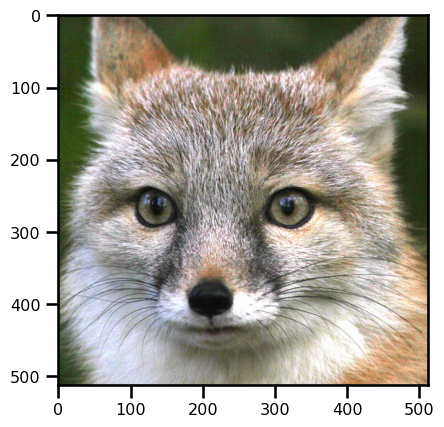

In [7]:
plt.figure()
plt.imshow(img)
plt.show()

### Data Module

In [43]:
# dm = ImageFox(batch_size=1024).setup()
dm = ImageCameraman(batch_size=4096).setup()

In [44]:
len(dm.ds_train)

131072

## Siren Net


### Sine Activation Layer

In [45]:
init = dm.ds_train[:32]
x_init, y_init = init
x_init.shape, y_init.shape

(torch.Size([32, 2]), torch.Size([32, 1]))

In [46]:
out = Sine()(x_init)

out.shape

torch.Size([32, 2])

In [47]:
# x_img = rearrange(out.numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [48]:
# plt.imshow(x_img)
# plt.show()

### Siren Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sin\left(\omega_0 \left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)\right)
$$

In [20]:
dim_in = x_init.shape[1]
dim_out = y_init.shape[1]
w0 = 1.0
c = 6.0

layer = Siren(
    dim_in=dim_in, dim_out=dim_out, 
    w0=w0, c=c, 
)

In [21]:
out = layer(x_init)

In [22]:
# x_img = rearrange(out.detach().numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [23]:
# plt.imshow(x_img)
# plt.show()

### Siren Network

In [24]:
dim_in = x_init.shape[1]
dim_hidden = 256
dim_out = y_init.shape[1]
num_layers = 3
w0 = 1.0
w0_initial = 30.0
c = 6.0

siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
)

In [25]:
out = siren_net(x_init)

In [26]:
# x_img = rearrange(out.detach().numpy(), "(x y) c -> x y c", x=img.shape[0], y=img.shape[0])

In [27]:
siren_net

SirenNet(
  (layers): ModuleList(
    (0): Siren(
      (activation): Sine()
    )
    (1): Siren(
      (activation): Sine()
    )
    (2): Siren(
      (activation): Sine()
    )
  )
  (last_layer): Siren(
    (activation): Identity()
  )
)

## Experiment

In [28]:
import pytorch_lightning as pl
pl.seed_everything(123)

Global seed set to 123


123

#### Dataset



In [29]:
learning_rate = 1e-4
siren_net = SirenNet(
    dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out,
    num_layers=num_layers,
    w0=w0, w0_initial=w0_initial,
)
dm = ImageCameraman(batch_size=4096).setup()

In [30]:
learn = ImageModel(siren_net, learning_rate=learning_rate)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [31]:
callbacks = [
    TQDMProgressBar(refresh_rate=100)
]

In [32]:
trainer = Trainer(
    min_epochs=1,
    max_epochs=3,
    accelerator="mps",
    enable_progress_bar=True,
    logger=None,
    callbacks=callbacks,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(learn, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.train_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /Users/eman/code_projects/ml4ssh/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type     | Params
-----------------------------------
0 | model | SirenNet | 132 K 
1 | loss  | MSELoss  | 0     
-----------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [35]:
trainer.test(learn, dataloaders=dm.test_dataloader())

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.08347434550523758    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08347434550523758}]

In [36]:
# t0 = time.time()
predictions = trainer.predict(learn, dataloaders=dm, return_predictions=True)
predictions = torch.cat(predictions)
# t1 = time.time() - t0

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 32it [00:00, ?it/s]

In [37]:
predictions.shape

torch.Size([262144, 1])

In [38]:
predictions.min(), predictions.max()

(tensor(-0.6253), tensor(1.9002))

In [39]:
from einops import rearrange

In [41]:
img_pred = dm.coordinates_2_image(predictions)

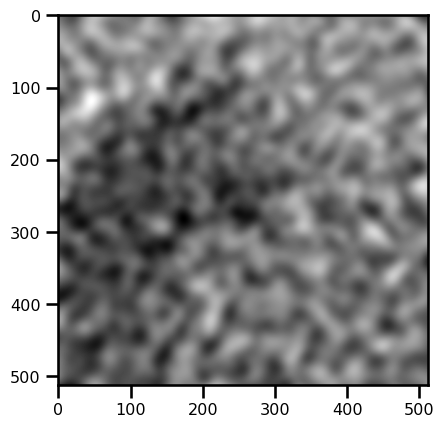

In [42]:
plt.figure()
plt.imshow(img_pred, cmap="gray")
plt.show()